<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Tensorflow_custom_models_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom models and training in TensorFlow

# Table of contents

1. [Introduction](#1)
2. [Dataset](#2)
3. [Custom loss functions](#3)
    1. [Saving/Loading models with custom objects](#3.1)
4. [Custom activation functions, initializers, regularizers and constraints](#4)
5. [Custom metrics](#5)
6. [Custom layers](#6)
7. [Custom models](#7)
8. [Custom training loops](#8)
    1. [Speeding up our training steo with `tf.function`](#8.1)
9. [References and further reading](#9)


# Introduction <a name="1"></a>

When we want to train a model with TensorFlow, the **95% of cases we** will not likely **require** anything else than TensorFlow’s high-level API, **`tf.keras`**. In other notebooks we have built various neural network architectures, including regression and classification nets, deep nets, and self-normalizing nets, using all sorts of techniques, such as Batch Normalization, dropout, learning rate schedules, and more. We also took a quick tour of TensorFlow and we saw the basic operations around tensors and other data structures. **In this notebook** we dive deeper into TensorFlow and take a look at its **lower-level Python API**.  This will be **useful when we need extra control**, to write **custom loss functions, custom metrics, layers, models, initializers, regularizers**, weight constraints, and more. We may even need to fully **control the training loop** itself, for example, to apply special transformations or constraints to the gradients, or to use multiple optimizers for different parts of the network.

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf

# Dataset <a name="2"></a>

In this notebook, we will be using the [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

In [2]:
# Load and prepare the California housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Custom loss functions <a name="3"></a>

Suppose we want to train a regression model, but our training set is a bit noisy. Of course, we cleaned up our dataset by fixing the outliers, but it turns out to be insufficient. Which loss function should we use? The mean squared error might penalize large errors too much. We can use the Huber loss (introduced in this [notebook](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/ML_metrics_and_cost_functions.ipynb)). The Huber loss is available in tf.keras ([`keras.losses.Huber`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber)), but let’s pretend it’s not there. Let's create a function that takes the labels and predictions as arguments, and use TensorFlow operations to compute every instance’s loss:

In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

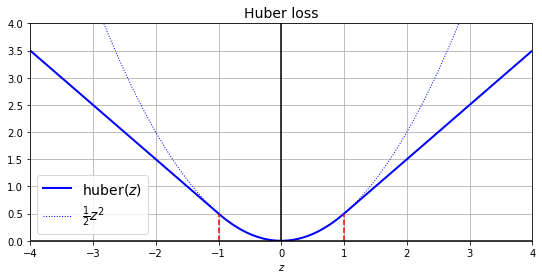

In [4]:
#@title
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(9, 4))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

**Note**: For better performance, we should use a **vectorized implementation**, as in this example. Moreover, if we want to benefit from TensorFlow’s graph features, we should **use only TensorFlow operations**.

It is also preferable to **return a tensor containing one loss per instance**, rather than returning the mean loss. This way, Keras can apply class weights or sample weights when requested.


Next, we can just use this loss when we compile the Keras model, then train our model:

In [5]:
input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6360 - mae: 1.0092 - val_loss: 0.3114 - val_mae: 0.6276
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2318 - mae: 0.5307 - val_loss: 0.2226 - val_mae: 0.5062


For each batch during training, Keras will call the `huber_fn()` function to compute the loss, and use it to perform a Gradient Descent step. Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.

## Saving/Loading models that contain custom components <a name="3.1"></a>

Saving a model containing a custom loss function actually works fine, as Keras just saves the name of the function. However, whenever we load it, we need to provide a dictionary that maps the function name to the actual function. More generally, when we load a model containing custom objects, we need to map the names to the objects:

In [6]:
model.save("my_model_with_a_custom_loss")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss/assets


In [7]:
model = keras.models.load_model("my_model_with_a_custom_loss",
                                custom_objects={"huber_fn": huber_fn})

In [8]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1900 - mae: 0.4693 - val_loss: 0.2033 - val_mae: 0.4709
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1756 - mae: 0.4471 - val_loss: 0.1893 - val_mae: 0.4551


With the current implementation of the huber loss, any error between -1 and 1 is considered “small”. But what if we want a different threshold? One solution is to create a function that creates a configured loss function:

In [9]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


In [10]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [11]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1913 - mae: 0.4415 - val_loss: 0.2253 - val_mae: 0.4489
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1860 - mae: 0.4345 - val_loss: 0.2004 - val_mae: 0.4483


Unfortunately, when we save the model, the threshold will not be saved. This means that we will have to specify the threshold value when loading the model (the name to use is "`huber_fn`", which is the name of the function we gave Keras, not the name of the function that created it):

In [12]:
model.save("my_model_with_a_custom_loss_threshold_2")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_threshold_2/assets


In [13]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [14]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1824 - mae: 0.4317 - val_loss: 0.2031 - val_mae: 0.4350
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1795 - mae: 0.4263 - val_loss: 0.1837 - val_mae: 0.4216


We can solve this by creating a subclass of the `keras.losses.Loss` class, and implement its `get_config()` method:

In [15]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        self.name = "HuberLoss"
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        tf.name_scope("name")
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- The constructor accepts `**kwargs` and passes them to the parent constructor, which handles standard arguments of the ``keras.losses.Loss` class: the name of the loss and the reduction algorithm to use to aggregate the individual instance losses. By default, it is "`sum_over_batch_size`", which means that the loss will be the sum of the instance losses, possibly weighted by the sample weights, if any, and then divide the result by the batch size. Other possible values are `"sum"` and `None`.

- The `call()` method takes the labels and predictions, computes all the instance losses, and returns them.

- The `get_config()` method returns a dictionary mapping each hyperparameter name to its value. It first calls the parent class’s `get_config()` method, then adds the new arguments to this dictionary.

We can then use any instance of this class when we compile the model:

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [17]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [18]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5518 - mae: 0.7794 - val_loss: 0.3422 - val_mae: 0.5804
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2517 - mae: 0.5193 - val_loss: 0.2300 - val_mae: 0.4817


When we save the model, the threshold will be saved along with it, and when we load the model we just need to map the class name to the class itself:

In [19]:
model.save("my_model_with_a_custom_loss_class")

INFO:tensorflow:Assets written to: my_model_with_a_custom_loss_class/assets


In [20]:
model = keras.models.load_model("my_model_with_a_custom_loss_class",
                                custom_objects={"HuberLoss": HuberLoss})
print(model.loss.threshold)

2.0


In [21]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2111 - mae: 0.4721 - val_loss: 0.2042 - val_mae: 0.4490
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1963 - mae: 0.4521 - val_loss: 0.1860 - val_mae: 0.4368


When we save a model, Keras calls the loss instance’s `get_config()` method and saves the config. When we load the model, it calls the `from_config()` class method on the `HuberLoss` class: this method is implemented by the base class (`keras.losses.Loss`) and just creates an instance of the class, passing `**config` to the constructor.

**Note**: The Keras API only specifies how to use subclassing to define layers, models, callbacks, and regularizers. If we build other components (such as losses, metrics, initializers or constraints) using subclassing, they may not be portable to other Keras implementations.

More information about how to save and load custom objects and functions is available in the [TensorFlow guide](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects).

# Custom activation functions, initializers, regularizers, and constraints <a name="4"></a>

Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, and layers can be customized in very much the same way. Most of the time, we will just need to write a simple function, with the appropriate inputs and outputs. For example, here are examples of a custom activation function (equivalent to `keras.activations.softplus`), a custom Glorot initializer (equivalent to `keras.initializers.glorot_normal`), a custom $l_1$ regularizer (equivalent to `keras.regularizers.l1(0.01)`) and a custom constraint that ensures weights are all positive (equivalent to `keras.constraints.nonneg()`):

In [22]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

As we can see, the arguments depend on the type of custom function. These custom functions can then be used normally, for example:

In [24]:
layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

- The activation function will be applied to the output of this `Dense` layer, and its result will be passed on to the next layer. 

- The layer’s weights will be initialized using the value returned by the initializer. 

- At each training step, the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. 

- Finally, the constraint function will be called after each training step, and the layer’s weights will be replaced by the constrained weights.

In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.2683 - mae: 0.7647 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.6426 - mae: 0.5444 - val_loss: inf - val_mae: inf


In [26]:
model.save("my_model_with_many_custom_parts")

INFO:tensorflow:Assets written to: my_model_with_many_custom_parts/assets


In [27]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

**If a function has some hyperparameters that need to be saved** along with the model, then we will want to **subclass the appropriate class**, such as `keras.regularizers.Regularizer`, `keras.constraints.Constraint`, `keras.initializers.Initializer` or `keras.layers.Layer` (for any layer, including activation functions). For example, much like we did for the custom loss, here is a simple class for $l_1$ regularization, that saves its `factor` hyperparameter (this time we do not need to call the parent constructor or the `get_config()` method, as they are not defined by the parent class):

In [28]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

Note that we must implement the `call()` method for losses, layers (including activation functions), and models, or the `__call__()` method for regularizers, initializers, and constraints. For metrics, things are a bit different, as we will see now.

In [29]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.1123 - mae: 0.7253 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.6057 - mae: 0.5370 - val_loss: 2.3830 - val_mae: 0.5363


In [30]:
model.save("my_model_with_many_custom_parts")

INFO:tensorflow:Assets written to: my_model_with_many_custom_parts/assets


In [31]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

# Custom metrics <a name="5"></a>

Losses and metrics are conceptually not the same things: losses are used by Gradient Descent to train a model, so they must be differentiable (at least where they are evaluated) and their gradients should not be 0 everywhere. Plus, it’s okay if they are not easily interpretable by humans (e.g. cross-entropy). In contrast, metrics are used to evaluate a model, they must be more easily interpretable, and they can be non-differentiable or have 0 gradients everywhere (e.g., accuracy).

That said, in most cases, defining a custom metric function is exactly the same as defining a custom loss function. In fact, we could even use the Huber loss function we created earlier as a metric (the Huber loss is seldom used as a metric, the MAE or MSE are preferred), it would work just fine (and persistence would also work the same way, in this case only saving the name of the function, "`huber_fn`" ):

In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])
# model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

history = model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.0826 - huber_fn: 0.9243
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.6068 - huber_fn: 0.2965


For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what we want. But not always! 

Consider a binary classifier’s precision, for example. The precision is the number of true positives divided by the number of positive predictions (including both true positives and false positives). Suppose the model made 5 positive predictions in the first batch, 4 of which were correct: that’s 80% precision. Then suppose the model made 3 positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If we just compute the mean of these two precisions, we get 40%. But wait for a second, this is not the model’s precision over these two batches! Indeed, there were a total of 4 true positives (4 + 0) out of 8 positive predictions (5 + 3), so the overall precision is 50%, not 40%.

What we need is an object that can keep track of the number of true positives and the number of false positives, and compute their ratio when requested. This is precisely what the `keras.metrics.Precision` class does:

In [33]:
precision = tf.keras.metrics.Precision()
print(precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]))
print(precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]))


tf.Tensor(0.8, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


In this example, we created a `Precision` object, then we used it as a function, passing it the labels and predictions for the first batch, then for the second batch (note that we could also have passed sample weights). We used the same number of true and false positives as in the example we just discussed. After the first batch, it returns the precision of 80%, then after the second batch, it returns 50% (which is the overall precision so far, not the second batch’s precision). This is called a streaming metric (or stateful metric), as it is gradually updated, batch after batch.

At any point, we can call the `result()` method to get the current value of the metric. We can also look at its variables (tracking the number of true and false positives) using the `variables` attribute, and reset these variables using the `reset_states()` method:

In [34]:
print(precision.result().numpy())
print(precision.variables)
precision.reset_states()

0.5
[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>, <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]


If we need to create such a streaming metric, we can just create a subclass of the `keras.metrics.Metric` class. Here is a simple example that keeps track of the total Huber loss and the number of instances seen so far. When asked for the result, it returns the ratio, which is simply the mean Huber loss:

In [35]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

- The constructor uses the `add_weight()` method to create the variables needed to keep track of the metric’s state over multiple batches, in this case, the sum of all Huber losses (`total`) and the number of instances seen so far (`count`). We could just create variables manually if we preferred. Keras tracks any `tf.Variable` that is set as an attribute (and more generally, any "trackable" object, such as layers or models).

- The `update_state()` method is called when we use an instance of this class as a function (as we did with the `Precision` object). It updates the variables given the labels and predictions for one batch (and sample weights, but in this case we just ignore them).

- The `result()` method computes and returns the final result, in this case just the mean Huber metric over all instances. When we use the metric as a function, the `update_state()` method gets called first, then the `result()` method is called, and its output is returned.

- We also implement the `get_config()` method to ensure the `threshold` gets saved along with the model.

- The default implementation of the `reset_states()` method just resets all variables to 0.0 (but we can override it if needed).

When we define a metric using a simple function, Keras automatically calls it for each batch, and it keeps track of the mean during each epoch, just like we did manually. So the only benefit of our `HuberMetric` class is that the `threshold` will be saved. But of course, some metrics, like precision, cannot simply be averaged over batches: in those cases, there’s no other option than to implement a streaming metric.

In [36]:
input_shape = X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
])

In [37]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.7665 - huber_metric: 0.7665
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2811 - huber_metric: 0.2811


In [38]:
model.save("my_model_with_a_custom_metric")

INFO:tensorflow:Assets written to: my_model_with_a_custom_metric/assets


In [39]:
model = keras.models.load_model("/content/my_model_with_a_custom_metric",
                               custom_objects={"huber_fn": create_huber(2.0),
                                               "HuberMetric": HuberMetric})

In [40]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2220 - huber_metric: 0.2220
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2013 - huber_metric: 0.2013


In [41]:
model.metrics[-1].threshold

2.0

Alternatively, we could have created the class in this way, which also supports sample weights.

In [42]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# Custom layers <a name="6"></a>

We may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. In this case, we will need to create a custom layer. Or sometimes we may simply want to build a very repetitive architecture, containing identical blocks of layers repeated many times, and it would be convenient to treat each block of layers as a single layer. For instance, in a ResNet50 model, we would have several ResNet blocks subclassing `Layer`, and a single `Model` encompassing the entire ResNet50 network.

First, some layers have no weights, such as `keras.layers.Flatten` or `keras.layers.ReLU`. If we want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a `keras.layers.Lambda layer`. For example, the following layer will apply the exponential function to its inputs:

In [43]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

This custom layer can then be used like any other layer, using the sequential API, the functional API, or the subclassing API. We can also use it as an activation function (or we could just use `activation=tf.exp`, or `activation=keras.activations.exponential`, or simply `activation="exponential"` ). The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales (e.g., $0.001$, $10.$, $1000.$).

To build a custom stateful layer (i.e., a layer with weights), we need to create a subclass of the `keras.layers.Layer` class. For example, the following class implements a simplified version of the Dense layer:

In [44]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", 
            shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal", 
            trainable=True
        )
        self.bias = self.add_weight(
            name="bias", 
            shape=[self.units], 
            initializer="zeros", 
            trainable=True
        )

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

- The constructor takes all the hyperparameters as arguments (in this example just `units` and `activation`), and it also takes a `**kwargs` argument. It calls the parent constructor, passing it the `kwargs`: this takes care of standard arguments such as `input_shape`, `trainable`, `name`, and so on. Then it saves the hyperparameters as attributes, converting the `activation` argument to the appropriate activation function using the `keras.activations.get()` function (it accepts functions, standard strings like `"relu"` or `"selu"` , or simply `None`) (this function is specific to `tf.keras`, we could use `keras.activations.Activation` instead).

- The `build()` method’s role is to create the layer’s variables, by calling the `add_weight()` method for each weight. The `build()` method is called the first time the layer is called. At that point, Keras will know the shape of this layer’s inputs, and it will pass it to the `build()` method (the Keras API calls this argument `input_shape`, but since it also includes the batch dimension, we prefer to call it `batch_input_shape`), which is often necessary to create some of the weights. For example, we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the `"kernel"`): this corresponds to the size of the last dimension of the inputs.

- The `call()` method actually performs the desired operations. In this case, we compute the matrix multiplication of the inputs `X` and the layer’s kernel, we add the bias vector, we apply the activation function to the result, and this gives us the output of the layer.

- The `compute_output_shape()` method simply returns the shape of this layer’s outputs. In this case, it is the same shape as the inputs, except the last dimension is replaced with the number of neurons in the layer. Note that in `tf.keras`, shapes are instances of the `tf.TensorShape` class, which we can convert to Python lists using `as_list()`.

- The `get_config()` method is just like earlier. Note that we save the activation function’s full configuration by calling `keras.activations.serialize()` . 

We can now use a `MyDense` layer just like any other layer!

In [45]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.1882 - val_loss: 2.1264
Epoch 2/2
162/162 [==============================] - 0s 811us/step - loss: 0.4988


0.4987967908382416

**Note**: We can generally omit the `compute_output_shape()` method, as `tf.keras` automatically infers the output shape, except when the layer is dynamic.

To create a layer with multiple inputs (e.g., `Concatenate`), the argument to the `call()` method should be a tuple containing all the inputs, and similarly, the argument to the `compute_output_shape()` method should be a tuple containing each input’s batch shape. To create a layer with multiple outputs, the `call()` method should return the list of outputs, and the `compute_output_shape()` should return the list of batch output shapes (one per output). For example, the following toy layer takes two inputs and returns two outputs:

In [46]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

This layer may now be used like any other layer, but of course only using the functional and subclassing APIs, not the sequential API (which only accepts layers with one input and one output).

In [47]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

If our layer needs to have a different behavior during training and during testing (e.g., if it uses `Dropout` or `BatchNormalization` layers), then we must add a `training` argument to the `call()` method and use this argument to decide what to do. For example, let’s create a layer that adds Gaussian noise during training (for regularization), but does nothing during testing (Keras actually has a layer that does the same thing: `keras.layers.GaussianNoise`):

In [48]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [49]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4809 - val_loss: 1.4488
Epoch 2/2
162/162 [==============================] - 0s 853us/step - loss: 0.3980


0.39801305532455444

More information about building custom layers is available [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

# Custom models <a name="7"></a>

We already looked at custom model classes when we discussed the subclassing API (see [notebook](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/Keras_Functional_API.ipynb#The-Subclassing-API)). It is actually quite straightforward, just subclass the `keras.models.Model` class, create layers and variables in the constructor, and implement the `call()` method to do whatever you want the model to do. For example, suppose we want to build the model represented in the next figure:

![](https://i.ibb.co/NTvMVbt/custom-model.png)

The inputs go through a first dense layer, then through a residual block composed of two dense layers and an addition operation (a residual block adds its inputs to its outputs), then through this same residual block 3 more times, then through a second residual block, and the final result goes through a dense output layer. This model does not make much sense, it’s just an example to illustrate the fact that we can easily build any kind of model we want, even containing loops and skip connections. To implement this model, it is best to first create a `ResidualBlock` layer, since we are going to create a couple of identical blocks (and we might want to reuse it in another model):

In [50]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="relu")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

This layer is a bit special since it contains other layers. This is handled transparently by Keras: it automatically detects that the hidden attribute contains trackable objects (layers in this case), so their variables are automatically added to this layer’s list of variables. Next, let’s use the subclassing API to define the model itself:

In [51]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

We create the layers in the constructor and use them in the `call()` method. This model can then be used like any other model (compile it, fit it, evaluate it, and use it to make predictions). If we also want to be able to save the model using the `save()` method, and load it using the `keras.models.load_model()` function, we must implement the `get_config()` method (as we did earlier) in both the `ResidualBlock` class and the `ResidualRegressor` class. Alternatively, we can just save and load the weights using the `save_weights()` and `load_weights()` methods.

The `Model` class is actually a subclass of the `Layer` class, so models can be defined and used exactly like layers. But a model also has some extra functionalities, including of course its `compile()`, `fit()`, `evaluate()` and `predict()` methods (and a few variants, such as `train_on_batch()` or `fit_generator()`), plus the `get_layers()` method (which can return any of the model’s layers by name or by index), and the `save()` method (and support for `keras.models.load_model()` and `keras.models.clone_model()`). So if models provide more functionalities than layers, why not just define every layer as a model? Well, technically we could, but it is probably cleaner to distinguish the internal components of our model (layers or reusable blocks of layers) from the model itself. The former should subclass the `Layer` class, while the latter should subclass the `Model` class.

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

X_new_scaled = X_test_scaled

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=3)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/3
363/363 [==============================] - 2s 2ms/step - loss: 0.6565
Epoch 2/3
363/363 [==============================] - 1s 2ms/step - loss: 0.4053
Epoch 3/3
162/162 [==============================] - 0s 1ms/step - loss: 0.3433


We could have defined the model using the sequential API instead:

In [53]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

With that, we can quite naturally and concisely build almost any model that we want, either using the sequential API, the functional API, the subclassing API, or even a mix of these. More information about building custom models is available [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class).

# Custom training loops <a name="8"></a> 

In some rare cases, the `fit()` method may not be flexible enough for what we need to do. For example, if we want to use two different optimizers. Since the `fit()` method only uses one optimizer (the one that we specify when compiling the model), implementing this requires writing our own custom loop.

We may also like to write our own custom training loops simply to feel more confident that it does precisely what we intended it to do. However, writing a custom training loop will make our code longer, more error-prone, and harder to maintain. Unless we really need the extra flexibility, we should prefer using the `fit()` method rather than implementing our own training loop.

First, let’s build a simple model. No need to compile it, since we will handle the training loop manually:

In [54]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next, let's prepare the datasets for training and validation.

In [55]:
batch_size = 32
# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid))
val_dataset = val_dataset.batch(batch_size)

Let’s define some hyperparameters, choose the optimizer, the loss function, and the metrics (just the MAE in this example):

In [56]:
n_epochs = 2
n_steps = len(X_train) // batch_size
progress_bar_values_names = ['loss', 'mse']
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.MeanSquaredError()
train_metric = keras.metrics.MeanAbsoluteError()
val_metric = keras.metrics.MeanAbsoluteError()

And now we are ready to build the custom loop:

In [57]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    progbar = tf.keras.utils.Progbar(
        target=n_steps, 
        stateful_metrics=progress_bar_values_names
    )
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the ops run during the forward pass
        with tf.GradientTape() as tape:
            y_pred = model(x_batch_train, training=True)
            # Compute the loss for this minibatch
            main_loss = loss_fn(y_batch_train, y_pred)
            loss = tf.add_n([main_loss] + model.losses)

        # Compute gradients of the trainable variables with respect to the loss
        gradients = tape.gradient(loss, model.trainable_weights)
        # Gradient descent step to update the weights to minimize the loss
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        # Update training metric
        train_metric.update_state(y_batch_train, y_pred)
        values = [('loss', loss), ('mse', train_metric.result())]
        progbar.update(step, values)
    # Display metrics at the end of each epoch
    train_mae = train_metric.result()
    print(f"Training mse over epoch: {float(train_mae):.4f}")
    # Reset training metric at the end of each epoch
    train_metric.reset_states()

    # Run a validation loop at the end of each epoch
    for x_batch_val, y_batch_val in val_dataset:
        y_pred_val = model(x_batch_val, training=False)
        # Update val metric
        val_metric.update_state(y_batch_val, y_pred_val)
    val_mae = val_metric.result()
    val_metric.reset_states()
    print(f"Validation mse: {float(val_mae):.4f}")

Epoch 1/2
362/362 [==============================] - 4s 12ms/step - loss: 0.5262 - mse: 0.5764
Training mse over epoch: 0.5764
Validation mse: 0.5220
Epoch 2/2
362/362 [==============================] - 4s 11ms/step - loss: 0.3898 - mse: 0.5093
Training mse over epoch: 0.5093
Validation mse: 0.4736


- We create two nested loops: one for the epochs, the other for the batches within an epoch. We use `tf.keras.utils.Progbar` to display a progress bar during each epoch. 

- Inside the `tf.GradientTape()` block, we make a prediction for one batch (using the model as a function), and we compute the loss: it is equal to the main loss (mse) plus the other losses (in this model, there is one regularization loss per layer). The `tf.add_n()` sums multiple tensors of the same shape and data type.

- Next, we ask the tape to compute the gradient of the loss with regards to each trainable variable, and we apply them to the optimizer to perform a Gradient Descent step. An explanation about how TensorFlow's autodiff works is available in the notebook [Tensorflow's autodifferentiation](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/TensorFlow%E2%80%99s_autodifferentiation.ipynb). If we want to apply any other transformation to the gradients, we can simply do so before calling the `apply_gradients()` method.

- Next, we update the training metrics (over the current step of the epoch), and we updated the progress bar.

- At the end of each epoch, we print the metric value in the training dataset, and we reset its state. We also compute the metric in the validation dataset and we print it.

As we can see, there are a lot of things we need to get right, it is easy to make a mistake. But on the bright side, we get full control.

**Note**: If we add weight constraints to your model (e.g., by setting `kernel_constraint` or `bias_constraint` when creating a layer), we should update the training loop to apply these constraints just after `apply_gradients()`:

```
for variable in model.variables:
    if variable.constraint is not None:
        variable.assign(variable.constraint(variable))
```

## Speeding-up our training step with `tf.function` <a name="8.1"></a> 

The default runtime in TensorFlow 2.0 is eager execution. This is great for debugging, but **graph compilation has a performance advantage** (more information about eager and graph modes in TensorFlow is available in this [notebook](https://nbviewer.jupyter.org/github/victorviro/Deep_learning_python/blob/master/TensorFlow_Eager_vs_Graph_execution.ipynb)). 

We can compile into a static graph any function that takes tensors as input. Just we have to add a `@tf.function` decorator on it. So, let's create a function that performs the training step and decorate it:

In [58]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        main_loss = loss_fn(y, y_pred)
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_metric.update_state(y, y_pred)
    return loss

Now, let's re-run our training loop with this compiled training step:

In [59]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    progbar = tf.keras.utils.Progbar(
        target=n_steps, 
        stateful_metrics=progress_bar_values_names
    )
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss = train_step(x_batch_train, y_batch_train)
        values = [('loss', loss), ('mse', train_metric.result())]
        progbar.update(step, values)
    
    train_mae = train_metric.result()
    print(f"Training mse over epoch: {float(train_mae):.4f}")
    train_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        y_pred_val = model(x_batch_val, training=False)
        val_metric.update_state(y_batch_val, y_pred_val)
    val_mae = val_metric.result()
    val_metric.reset_states()
    print(f"Validation mse: {float(val_mae):.4f}")

Epoch 1/2
362/362 [==============================] - 1s 3ms/step - loss: 0.7104 - mse: 0.5096
Training mse over epoch: 0.5096
Validation mse: 0.4891
Epoch 2/2
362/362 [==============================] - 1s 1ms/step - loss: 0.5323 - mse: 0.5094
Training mse over epoch: 0.5094
Validation mse: 0.4897


# References and further reading <a name="9"></a>

- [TensorFlow: Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

- [TensorFlow: Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize)

- [TensorFlow: Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)